# The basics of Bayesian optimization

Many real-world problems involve optimization of functions which are difficult, or costly, to evaluate. For instance, in deep learning, finding the optimal hyperparameters and architecture of a neural network is a cumbersome process that should ideally be automated with as little fuction evaluations (i.e. training the networks) as possible.

For problems like these, Bayesian optimization (BO) offers a unifying framework where the function to evaluate is approximated using a surrogate model, for instance a Gaussian process. In this notebook, we introduce the basics of BO.

We load some libraries first.

In [1]:
suppressMessages({    
    library(tidyverse)    
    library(colorspace)    
    library(rstan)
    library(bayesplot)
})

set.seed(23)

In [35]:
scatterplot <- function(
    x.true, y.true, f_star=NULL, f_star_var=NULL, data=NULL) {
    df <- data.frame(x=x.true, y=y.true)
   
    g <- ggplot() +       
        theme(axis.line.x = element_line(color="black", size = .25),
              axis.line.y = element_line(color="black", size = .25))

    if (!is.null(f_star) && !is.null(f_star_var)) {
        df_star <- data.frame(
            x=x.true,
            y=f_star, 
            lower=f_star - sqrt(f_star_var), 
            upper=f_star + sqrt(f_star_var))
        g <- g + 
            geom_ribbon(data=df_star, aes(x, ymin = lower, ymax = upper, fill="#DCBCBC")) +             
            geom_line(data=df_star, aes(x, y, color="darkred"))
    }
    if (!is.null(data)) {
        g <- g + geom_point(data=data, aes(x, y, color="darkred")) 
    }
    
    g + 
     geom_line(data=df, aes(x, y, color="darkgrey")) +
     scale_color_manual(
            breaks = c("darkgrey", "darkred", "black"), 
            labels = c("Function to optimize", "Posterior", "Acquisition function"),
            values = c("darkgrey", "darkred", "black")
        ) +
        scale_fill_manual(
            breaks = c("lightgrey", "darkred", "#DCBCBC"),
            values = c("lightgrey", "darkred", "#DCBCBC")
        ) +
    labs(color = "Legend") +
    guides(fill=FALSE)
}

Usually the function to maximize is difficult/infeasible to query and the number of functions evaluations and we want to minimize the number as much as possible. In this example, we demonstration BO on the example function below.

In [3]:
f <- function(x) cos(4 * x) + exp(-(x ** 2) / 2)

Without loss of generality, we constrain the optimization on a set of $n$ points in the interval $x \in [-5, 5]$, such that we don't need to write to much boilerplate code.

In [4]:
n <- 1000

x.init = seq(-5, 5, length.out = n)
y.init = f(x.init)

Below is the function to optimize:

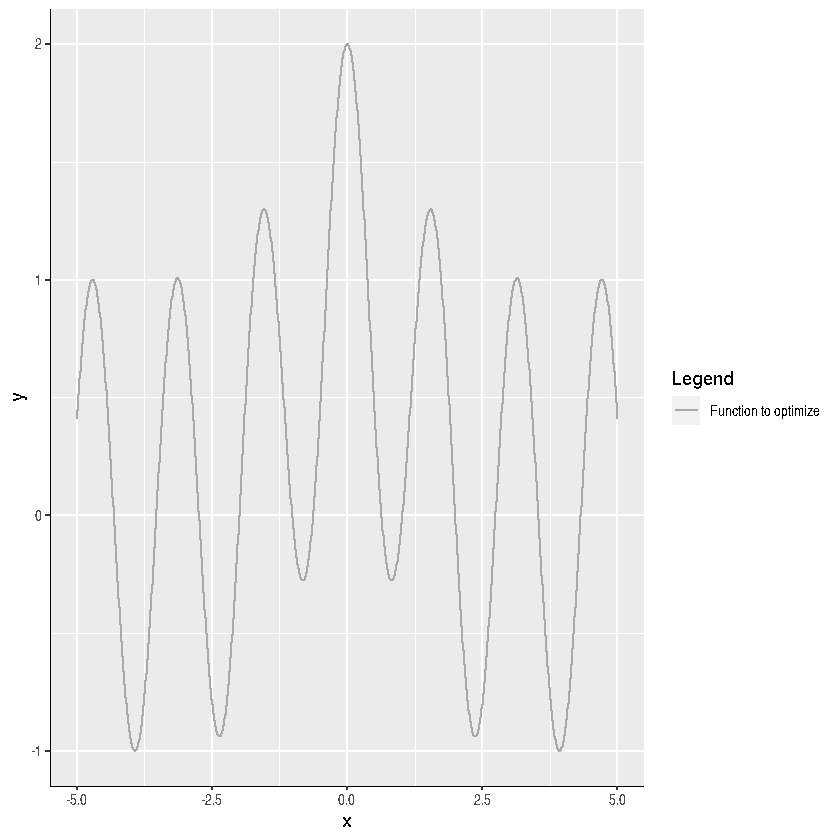

In [13]:
scatterplot(x.init, y.init)

To optimize this function, we define functions to fit a surrogate model and make a predict using the model fit. We use Stan to implement the surrogate model for which we use a Gaussian process.

In [14]:
surrogate.model.file <- "_models/bo-surrogate.stan"
cat(readLines(surrogate.model.file), sep="\n")

data {
	int<lower=1> N;	
	real x[N];
	vector[N] y;

	int<lower=1> N_star;
	real x_star[N_star];

	real<lower=0> rho;
	real<lower=0> alpha;
	real<lower=0> sigma;
}

parameters {}

model {}

generated quantities {
	vector[N_star] f_star;
	vector[N_star] f_star_cov;	

    {
      matrix[N, N] K =  cov_exp_quad(x, alpha, rho)
                         + diag_matrix(rep_vector(square(sigma), N));
      matrix[N, N] L_K = cholesky_decompose(K);

      vector[N] L_K_div_y = mdivide_left_tri_low(L_K, y);
      vector[N] K_div_y = mdivide_right_tri_low(L_K_div_y', L_K)';
      
      matrix[N, N_star] k_x_x_star = cov_exp_quad(x, x_star, alpha, rho);
      
     
      matrix[N, N_star] v_pred = mdivide_left_tri_low(L_K, k_x_x_star);
      matrix[N_star, N_star] cov_f2 = cov_exp_quad(x_star, alpha, rho) - v_pred' * v_pred
		+ diag_matrix(rep_vector(1e-10, N_star));

		f_star = (k_x_x_star' * K_div_y);
		f_star_cov = diagonal(cov_f2);
	}

}


In [54]:
gp <- stan_model(file = surrogate.model.file)

In [83]:
predict.gp <- function(gp, x, y, x.star) {
    dat <- list(
        N=length(x),
        x=as.vector(x),
        y=as.vector(y),
        N_star=length(x.star),
        x_star=x.star,
        rho=1,
        alpha=1,
        sigma=1
    )
    
    pred <- rstan::sampling(gp, dat, chains=1, algorithm="Fixed_param", iter=1)

    ext <- rstan::extract(pred)
    f.star <- as.vector(ext$f_star)
    f.star.var <- as.vector(ext$f_star_cov)
    
    
    list(f.star, f.star.var)
}

In [69]:
. <- predict.gp(gp, x.init[1:2], y.init[1:2], x.init)


SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.023694 seconds (Sampling)
Chain 1:                0.023694 seconds (Total)
Chain 1: 


As acquisition function we use the upper confidence bound.

In [27]:
acquisition.function <- function(gp, x.d, y.d, x.init, conf) {
    preds <- predict.gp(gp, x.d, y.d, x.init)
    f.star <- preds[[1]]
    f.star.var <- preds[[2]]
    ucb <- f.star + conf * sqrt(f.star.var)
    ucb
}

Finally, we define a function that proposes the next point to evaluate.

In [28]:
acquire <- function(x.d, y.d, x.init, conf=2.0) {
    preds <- predict.gp(gp, x.d, y.d, x.init)
    f.hat <- preds[[1]]
    f.star.var <- preds[[2]]

    ucb <- acquisition.function(gp, x.d, y.d, x.init, conf)
    x.next <- x.init[which.max(ucb)]
    list(x.next=x.next, ucb=ucb, f.hat=f.hat, f.star.var=f.star.var)
}    

We start with a random point on the interval defined above and query it against the function that we want to evaluate

In [89]:
set.seed(23)

x.d <- runif(2, -5, 5)
y.d <- f(x.d)

Then we train the surrogate model, and use the aquisition function to propose a new point.

In [92]:
iter <- acquire(x.d, y.d, x.init)
x.n <- iter$x.next
ucb <- iter$ucb
f.star <- iter$f.star
f.star.var <- iter$f.star.var


SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.023207 seconds (Sampling)
Chain 1:                0.023207 seconds (Total)
Chain 1: 

SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.02356 seconds (Sampling)
Chain 1:                0.02356 seconds (Total)
Chain 1: 


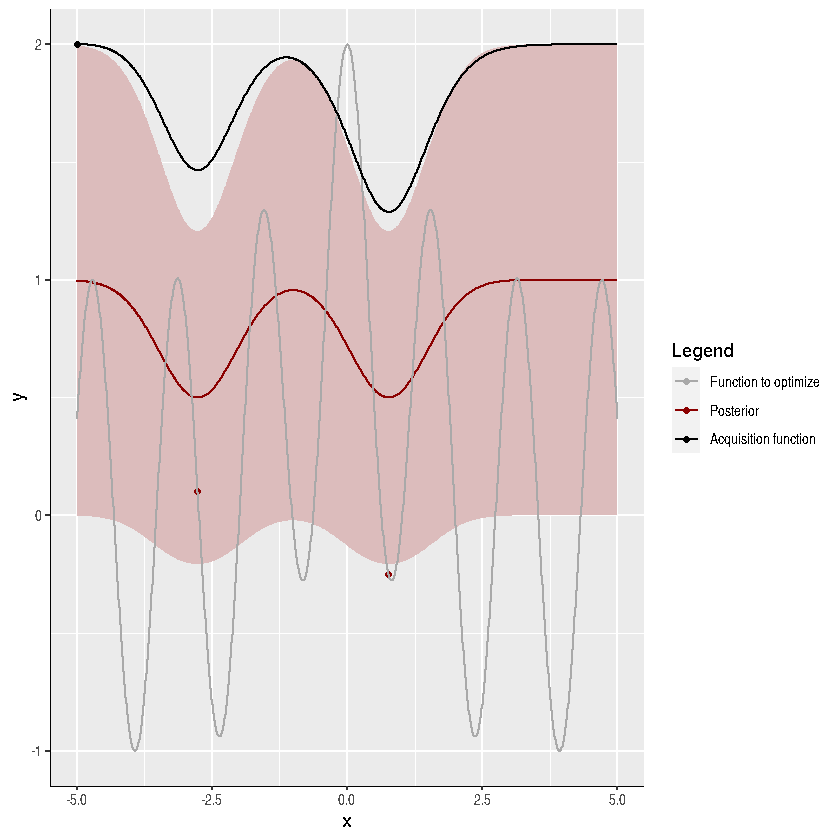

In [93]:
g <- scatterplot(x.init, y.init, f.star, f.star.var, data=data.frame(x=x.d, y=y.d))
g + geom_line(data=data.frame(x=x.init, y=ucb), aes(x, y, color="black")) +
    geom_point(data=data.frame(x=x.n, y=max(ucb)), aes(x, y))

In [98]:
y.n <- f(x.n)
x.d <- c(x.d, x.n)
y.d <- c(y.d, y.n)

In [101]:
iter <- acquire(x.d, y.d, x.init)


SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.023108 seconds (Sampling)
Chain 1:                0.023108 seconds (Total)
Chain 1: 

SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.022231 seconds (Sampling)
Chain 1:                0.022231 seconds (Total)
Chain 1: 


In [102]:
x.n <- iter$x.next
ucb <- iter$ucb
f.star <- iter$f.star
f.star.var <- iter$f.star.v

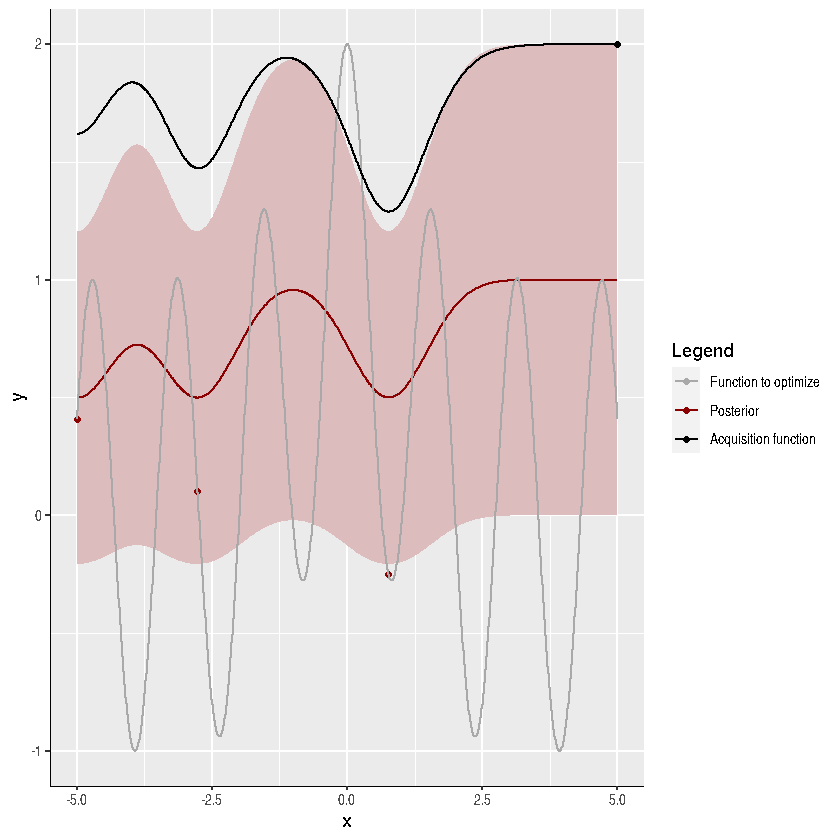

In [103]:
g <- scatterplot(x.init, y.init, f.star, f.star.var, data=data.frame(x=x.d, y=y.d))
g + geom_line(data=data.frame(x=x.init, y=ucb), aes(x, y, color="black")) +
    geom_point(data=data.frame(x=x.n, y=max(ucb)), aes(x, y))

In [106]:
y.n <- f(x.n)
x.d <- c(x.d, x.n)
y.d <- c(y.d, y.n)

In [107]:
iter <- acquire(x.d, y.d, x.init)


SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.02298 seconds (Sampling)
Chain 1:                0.02298 seconds (Total)
Chain 1: 

SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.021686 seconds (Sampling)
Chain 1:                0.021686 seconds (Total)
Chain 1: 


In [108]:
x.n <- iter$x.next
ucb <- iter$ucb
f.star <- iter$f.star
f.star.var <- iter$f.star.v

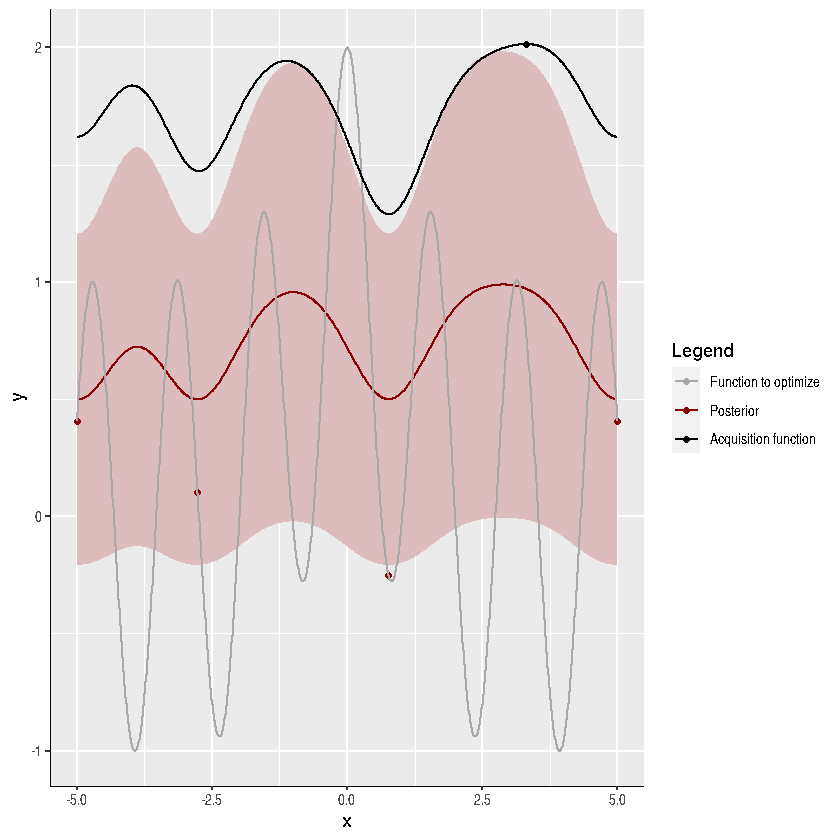

In [109]:
g <- scatterplot(x.init, y.init, f.star, f.star.var, data=data.frame(x=x.d, y=y.d))
g + geom_line(data=data.frame(x=x.init, y=ucb), aes(x, y, color="black")) +
    geom_point(data=data.frame(x=x.n, y=max(ucb)), aes(x, y))

In [121]:
for (i in seq(10)) {
    y.n <- f(x.n)
    x.d <- c(x.d, x.n)
    y.d <- c(y.d, y.n)
    iter <- acquire(x.d, y.d, x.init)
    x.n <- iter$x.next
}


SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.028519 seconds (Sampling)
Chain 1:                0.028519 seconds (Total)
Chain 1: 

SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.028569 seconds (Sampling)
Chain 1:                0.028569 seconds (Total)
Chain 1: 

SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.028508 seconds (Sampling)
Chain 1:                0.028508 seconds (Total)
Chain 1: 

SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.029689 seconds (Sampling)
Chain 1:           

In [122]:
ucb <- iter$ucb
f.star <- iter$f.star
f.star.var <- iter$f.star.v

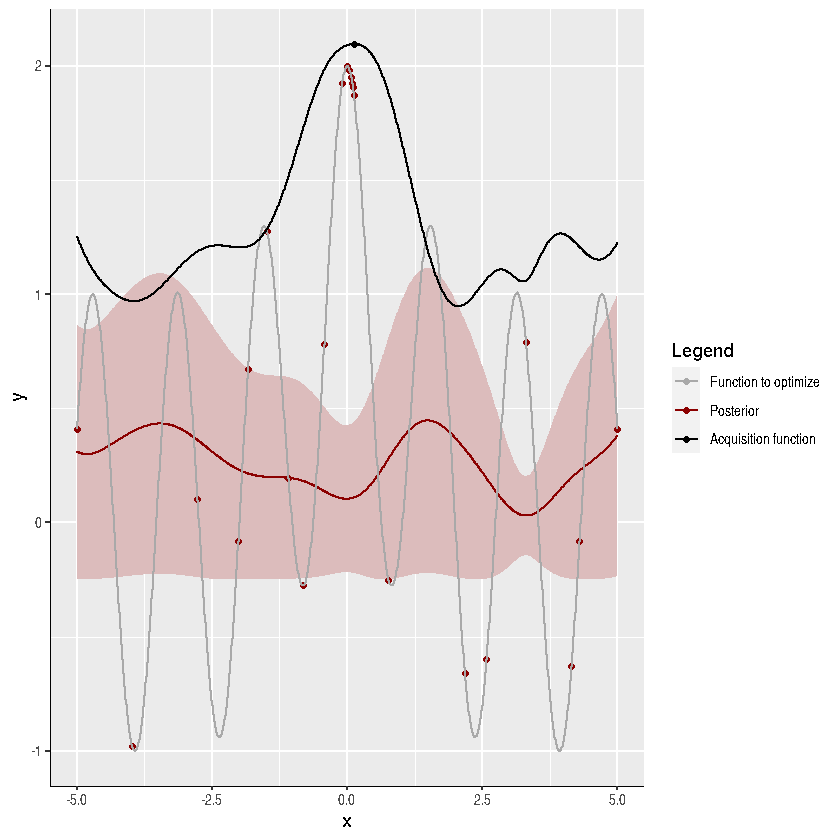

In [123]:
g <- scatterplot(x.init, y.init, f.star, f.star.var, data=data.frame(x=x.d, y=y.d))
g + geom_line(data=data.frame(x=x.init, y=ucb), aes(x, y, color="black")) +
    geom_point(data=data.frame(x=x.n, y=max(ucb)), aes(x, y))

## Batch Bayesian optimization

In cases where we want to query multiple points at once, we need to come up with another strategy. One way to do that is, to propose a new point, then penalize the acquisition function around the region of the proposed point, and then propose another point by using the penalized acquisition function.

Below we demonstrate the proposed method by [Gonzales *et al.*](http://proceedings.mlr.press/v51/gonzalez16a.pdf).

First we define some required functions.

In [125]:
m <- function(gp, x.init) {
    pred <- predict.gp(gp, x.init)
    y.hat <- pred[[1]]
    max(y.hat)
}

We approximate the gradient of the posterior predictive mean using finite differences.

In [127]:
posterior.gradient <- function(gp, x.init) {
    h <- 0.00000000001
    y.hat <- predict.gp(gp, x.init)[[1]]
    y.h.hat <- predict.gp(gp, x.init + h)[[1]]
    y.hat.grad = (y.h.hat - y.hat) / h
    
    list(y.hat=y.hat, y.h.hat=y.h.hat)
}

In [128]:
lipschitz <- function(gp, x.init) {
    y.hat.grad <- posterior.gradient(gp, x.init)[[2]]
    max(sqrt(y.hat.grad ** 2))
}
    

The function $\phi$ penalizes the acquisiation function around a point $\mathbf{x}_j$.

In [ ]:
phi <- function(gp, x, x.j, L, M) {
    y_hat, y_hat_var = predict_gp(gp, np.atleast_2d(x_j))
    dist = distance.cdist(np.atleast_2d(x), np.atleast_2d(x_j))

    z = (L * dist - M + y_hat) / (np.sqrt(2 * y_hat_var))
    z = 0.5 * sp.special.erfc(-z)
    z
}